In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import scienceplots
# plt.style.use(['science', 'grid'])   
import xarray

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import copy
import datetime
from tqdm import tqdm

import dynamic_tasker.imagery as imagery
from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *

%load_ext autoreload
%autoreload 2

In [81]:
requests = load_worldcities(10000)
h = 400
t0 = datetime.datetime(2025, 1, 1, 6, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
t_orbit = t_orb(orbit)
print("Orbit period: ", t_orbit)
t_end = datetime.datetime(2025, 1, 1, 18, 0, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)
accesses_omni = [x for x in accesses if x.state == 1]

t_s = 10
t_dotsq = 4

def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

Orbit period:  5553.455896959871


In [82]:
CoverageZone = namedtuple("CoverageZone", ["sat_idx", "time"])

# Apply states
def get_sat_idx(long):
    center_lons = [x["lon"] for x in imagery.image_sources.values()]
    center_lon_sorted = np.sort(center_lons)
    center_lon_cutoffs = (center_lon_sorted + np.roll(center_lon_sorted, 1)) / 2
    center_lon_cutoffs[0] -= 180

    sat_idx = np.searchsorted(center_lon_cutoffs, long) - 1

    if(sat_idx == -1):
        sat_idx = 4

    return sat_idx

def apply_access_states(accesses, time: datetime.datetime=None, round_to=30, 
                        data_delay=datetime.timedelta(minutes=0), access_interval=None, t_start=None):
    old_cov_idx = -1
    labels = list(imagery.image_sources.keys())
    rng = np.random.default_rng()
    
    unique_maps = []
    
    # First pass: Build a list of unique coverage maps based on each access’s computed time and satellite index.
    for a in accesses:
        if time is None:
            t = a.time
            # If an access_interval is provided, round the time to the nearest interval.
            if access_interval is not None:
                total_access = (t - t_start).total_seconds() / access_interval
                t = t_start + datetime.timedelta(seconds=np.floor(total_access) * access_interval)
            t = t.replace(second=0, microsecond=0)
            t = t - datetime.timedelta(minutes=t.minute % round_to) - data_delay
        else:
            t = time

        sat_idx = get_sat_idx(a.long)
        
        # Add a new coverage map only if it differs from the previous one.
        if not unique_maps or (unique_maps[-1].time != t or unique_maps[-1].sat_idx != sat_idx):
            unique_maps.append(CoverageZone(sat_idx, t))
            # Optionally, uncomment for debugging:
            # print(f"New map at {t} for satellite {list(imagery.image_sources.values())[sat_idx]['description']}")

    # Second pass: For each access, use the computed time to find the corresponding coverage map.
    for a in tqdm(accesses):
        if time is None:
            t = a.time
            if access_interval is not None:
                total_access = (t - t_start).total_seconds() / access_interval
                t = t_start + datetime.timedelta(seconds=np.floor(total_access) * access_interval)
            t = t.replace(second=0, microsecond=0)
            t = t - datetime.timedelta(minutes=t.minute % round_to) - data_delay
        else:
            t = time

        sat_idx = get_sat_idx(a.long)
        
        # Find the index of the coverage map that matches this satellite and time.
        cov_idx = -1
        for i, m in enumerate(unique_maps):
            if (sat_idx, t) == (m.sat_idx, m.time):
                cov_idx = i
                break

        if cov_idx == -1:
            raise ValueError(f"Could not find coverage map for {sat_idx} at {t}")

        # Load a new coverage map if it's a new one.
        if cov_idx != old_cov_idx:
            filename = f"{labels[sat_idx]}_{t.strftime(imagery.dateformat)}." \
                       f"{'grb' if labels[sat_idx].startswith('meteosat') else 'nc'}"
            data, lats, lons = imagery.load_bcm(filename)
            old_cov_idx = cov_idx

        mask = imagery.get_closest_latlong_sample(data, lats, lons, (a.lat, a.long))
        a.state = mask
        a.utility = 1  # Alternatively, you might assign mask directly or compute a different utility.

    return accesses

apply_access_states(accesses)

accesses_omni = [x for x in accesses if x.state == 1]
schedule_conventional = milp_schedule(accesses, requests, agility_bangbang)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:49<00:00, 67.68it/s]


feasible solution found by trivial heuristic after 0.1 seconds, objective value 8.000000e+00
presolving:
(round 1, fast)       57 del vars, 31 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 83264 clqs
(round 2, fast)       76 del vars, 61 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 83234 clqs
(round 3, exhaustive) 76 del vars, 61 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 83234 upgd conss, 0 impls, 83234 clqs
   (0.4s) probing: 51/3263 (1.6%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.4s) probing aborted: 50/50 successive totally useless probings
   (0.7s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (1.3s) symmetry computation finished: 730 generators found (max: 1500, log10 of symmetry group size: 370.0) (symcode time: 0.58)
dynamic symmetry handling statistics:
   orbitopal reduction:       no component

In [83]:
schedule_omniscient = milp_schedule(accesses_omni, requests, agility_bangbang)

feasible solution found by trivial heuristic after 0.0 seconds, objective value 1.200000e+01
presolving:
(round 1, fast)       74 del vars, 39 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52890 clqs
(round 2, fast)       103 del vars, 73 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52856 clqs
(round 3, fast)       105 del vars, 74 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52855 clqs
(round 4, exhaustive) 106 del vars, 74 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52855 upgd conss, 0 impls, 52855 clqs
   (0.2s) probing: 51/1814 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.2s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.5s) symmetry computation finished: 437 generators found (max: 1500

In [84]:
print(f"Omniscient: {len(schedule_omniscient)}, {schedule_omniscient}")
print(f"Conventional: {len(schedule_conventional)}, {schedule_conventional}")

Omniscient: 232, [Access(2004, 50.4333, 80.2667, Semey, 2025-01-01 06:00:11.230469, -17.855621875097416, 1.0, 1), Access(1792, 49.9833, 82.6167, Oskemen, 2025-01-01 06:00:35.644531, -23.345507559997795, 1.0, 1), Access(553, 47.9203, 106.9172, Ulaanbaatar, 2025-01-01 06:04:52.480469, 1.3899408341227428, 1.0, 1), Access(181, 42.257, 118.888, Chifeng, 2025-01-01 06:07:34.589844, -14.26190458428523, 1.0, 1), Access(294, 41.129, 121.148, Jinzhou, 2025-01-01 06:08:06.816406, -14.303586340928243, 1.0, 1), Access(357, 40.625, 122.219, Yingkou, 2025-01-01 06:08:22.441406, -13.524165243827564, 1.0, 1), Access(1348, 37.3833, 126.9333, Anyang, 2025-01-01 06:09:40.566406, -18.951906063673373, 1.0, 1), Access(7708, 35.55, 134.8167, Toyooka, 2025-01-01 06:11:17.246094, 23.72820802430388, 1.0, 1), Access(7011, 35.0167, 135.5667, Kameoka, 2025-01-01 06:11:30.917969, 24.326473945465132, 1.0, 1), Access(8293, -17.8, 177.4167, Nadi, 2025-01-01 06:29:10.488281, 9.256285457442225, 1.0, 1), Access(8973, 33.5

In [85]:
# data_delay = datetime.timedelta(minutes=0)
# timestep = datetime.timedelta(minutes=30)

# current_time = t0
# schedule = []
# accesses_working = copy.deepcopy(accesses)

# print(accesses_working)
# print(t0)

# def agility_reachable(a1, a2):
#     return a1.time + datetime.timedelta(seconds=agility_bangbang(a2.angle - a1.angle)) >= a2.time

# for i in range((t_end - t0).seconds // timestep.seconds):
#     accesses_current = [x for x in accesses_working if x.time <= current_time + i * timestep and x.time >= current_time + (i-1) * timestep]
#     if(len(schedule) > 0):
#         accesses_current = [x for x in accesses_current if agility_reachable(schedule[-1], x)]
        
#     apply_access_states(accesses_current, current_time + (i * timestep) - data_delay)
#     accesses_current = [x for x in accesses_current if x.state == 1]
#     # print(accesses_current)
#     schedule_current = milp_schedule(accesses_current, requests, agility_bangbang)
#     print(schedule_current)
#     # schedule.extend(schedule_current)

# # Apply the true access states
# apply_access_states(schedule)



In [86]:
# Ok try with data delay...

delays = [datetime.timedelta(minutes=x) for x in [0, 30, 60, 90, 120]]
schedules = []
for t_start, access_interval in tqdm(zip([t0, None], [t_orbit/2, None])):
    for d in tqdm(delays):
        accesses_working = copy.deepcopy(accesses)
        apply_access_states(accesses_working, data_delay=d, t_start=t_start, access_interval=access_interval)
        accesses_working = [x for x in accesses_working if x.state == 1]
        schedule_working = milp_schedule(accesses_working, requests, agility_bangbang)
        # Apply the true access states
        apply_access_states(schedule_working)
        schedules.append(copy.deepcopy(schedule_working))

# Print the schedules
print(len(schedules))


0it [00:00, ?it/s]





























100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:47<00:00, 70.80it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 1.100000e+01
presolving:
(round 1, fast)       79 del vars, 43 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52197 clqs
(round 2, fast)       112 del vars, 64 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52176 clqs
(round 3, fast)       115 del vars, 69 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52171 clqs
(round 4, exhaustive) 116 del vars, 69 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52171 upgd conss, 0 impls, 52171 clqs
   (0.2s) probing: 51/1779 (2.9%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.2s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.6s) symmetry computation finished: 431 generators found (max: 1500





























100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:40<00:00,  5.88it/s]






























100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:48<00:00, 68.83it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 1.000000e+01
presolving:
(round 1, fast)       66 del vars, 40 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52357 clqs
(round 2, fast)       98 del vars, 80 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52317 clqs
(round 3, fast)       102 del vars, 82 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52315 clqs
(round 4, fast)       104 del vars, 82 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52315 clqs
(round 5, exhaustive) 104 del vars, 82 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52315 upgd conss, 0 impls, 52315 clqs
   (0.2s) probing: 51/1806 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.2s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started:





























100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:41<00:00,  5.63it/s]






























100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:47<00:00, 70.38it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 8.000000e+00
presolving:
(round 1, fast)       67 del vars, 39 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52237 clqs
(round 2, fast)       96 del vars, 70 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52206 clqs
(round 3, exhaustive) 96 del vars, 70 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52206 upgd conss, 0 impls, 52206 clqs
   (0.2s) probing: 51/1822 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.2s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.5s) symmetry computation finished: 434 generators found (max: 1500, log10 of symmetry group size: 200.0) (symcode time: 0.11)
dynamic symmetry handling statistics:
   orbitopal reduction:       no component

    1 |     0 |  2083 |     - |   256M |   0 |1073 |  34k|  34k| 128 |  3 |   0 |   0 | 5.135000e+02 | 2.310000e+02 | 122.29%| unknown
  208s|     1 |     0 |  2384 |     - |   261M |   0 |1073 |  34k|  34k| 163 |  4 |   0 |   0 | 4.840000e+02 | 2.310000e+02 | 109.52%| unknown
  209s|     1 |     0 |  2772 |     - |   265M |   0 |1073 |  34k|  34k| 204 |  5 |   0 |   0 | 4.560000e+02 | 2.310000e+02 |  97.40%| unknown
  211s|     1 |     0 |  3119 |     - |   268M |   0 |1073 |  34k|  34k| 250 |  6 |   0 |   0 | 4.307500e+02 | 2.310000e+02 |  86.47%| unknown
  211s|     1 |     0 |  3542 |     - |   272M |   0 |1073 |  34k|  34k| 322 |  7 |   0 |   0 | 3.975000e+02 | 2.310000e+02 |  72.08%| unknown
  212s|     1 |     0 |  3832 |     - |   276M |   0 |1073 |  34k|  34k| 398 |  8 |   0 |   0 | 3.773452e+02 | 2.310000e+02 |  63.35%| unknown
  212s|     1 |     0 |  4247 |     - |   280M |   0 |1073 |  34k|  34k| 462 |  9 |   0 |   0 | 3.633375e+02 | 2.310000e+02 |  57.29%| unknown
  213s|





























100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:39<00:00,  5.97it/s]





























100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:47<00:00, 69.74it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 9.000000e+00
presolving:
(round 1, fast)       66 del vars, 36 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52110 clqs
(round 2, fast)       95 del vars, 64 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52082 clqs
(round 3, fast)       99 del vars, 67 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52079 clqs
(round 4, fast)       102 del vars, 67 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52079 clqs
(round 5, exhaustive) 102 del vars, 67 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52079 upgd conss, 0 impls, 52079 clqs
   (0.2s) probing: 51/1807 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.2s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started: 




























100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:38<00:00,  6.18it/s]






























100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:46<00:00, 72.53it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 8.000000e+00
presolving:
(round 1, fast)       68 del vars, 38 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52566 clqs
(round 2, fast)       100 del vars, 81 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52523 clqs
(round 3, fast)       102 del vars, 83 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52521 clqs
(round 4, fast)       104 del vars, 83 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52521 clqs
(round 5, exhaustive) 104 del vars, 83 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52521 upgd conss, 0 impls, 52521 clqs
   (0.2s) probing: 51/1845 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.2s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started

%| unknown
  345s|     1 |     0 |  9375 |     - |   336M |   0 |1070 |  34k|  34k|1178 | 74 |   0 |   0 | 2.415664e+02 | 2.390000e+02 |   1.07%| unknown
  345s|     1 |     0 |  9389 |     - |   336M |   0 |1070 |  34k|  34k|1183 | 75 |   0 |   0 | 2.415644e+02 | 2.390000e+02 |   1.07%| unknown
  345s|     1 |     0 |  9416 |     - |   337M |   0 |1070 |  34k|  34k|1189 | 76 |   0 |   0 | 2.415317e+02 | 2.390000e+02 |   1.06%| unknown
  345s|     1 |     0 |  9457 |     - |   337M |   0 |1070 |  34k|  34k|1195 | 77 |   0 |   0 | 2.412804e+02 | 2.390000e+02 |   0.95%| unknown
  345s|     1 |     0 |  9457 |     - |   337M |   0 |1070 |  34k|  34k|1195 | 77 |   0 |   0 | 2.412804e+02 | 2.390000e+02 |   0.95%| unknown
  345s|     1 |     0 |  9479 |     - |   337M |   0 |1070 |  33k|  34k|1200 | 78 |   0 |   0 | 2.412199e+02 | 2.390000e+02 |   0.93%| unknown
  345s|     1 |     0 |  9483 |     - |   337M |   0 |1070 |  33k|  34k|1202 | 79 |   0 |   0 | 2.412083e+02 | 2.390000e+02 |   0.9



























100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [28:43<00:00, 344.63s/it]
1it [28:43, 1723.15s/it]































100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:49<00:00, 68.04it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 1.200000e+01
presolving:
(round 1, fast)       74 del vars, 39 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52890 clqs
(round 2, fast)       103 del vars, 73 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52856 clqs
(round 3, fast)       105 del vars, 74 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52855 clqs
(round 4, exhaustive) 106 del vars, 74 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52855 upgd conss, 0 impls, 52855 clqs
   (0.2s) probing: 51/1814 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.2s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.6s) symmetry computation finished: 437 generators found (max: 1500

9527 |     - |   332M |   0 |1096 |  11k|  11k|1188 | 77 |   0 |   0 | 2.380000e+02 | 2.370000e+02 |   0.42%| unknown
r 251s|     1 |     0 |  9527 |     - |rounding|   0 |1096 |  11k|9400 |1188 | 77 |   0 |   0 | 2.380000e+02 | 2.380000e+02 |   0.00%| unknown
  251s|     1 |     0 |  9527 |     - |   333M |   0 |1096 |  11k|9400 |1188 | 77 |   0 |   0 | 2.380000e+02 | 2.380000e+02 |   0.00%| unknown
  251s|     1 |     0 |  9527 |     - |   333M |   0 |1096 |  11k|9400 |1188 | 77 |   0 |   0 | 2.380000e+02 | 2.380000e+02 |   0.00%| unknown

SCIP Status        : problem is solved [optimal solution found]
Solving Time (sec) : 251.20
Solving Nodes      : 1
Primal Bound       : +2.38000000000000e+02 (116 solutions)
Dual Bound         : +2.38000000000000e+02
Gap                : 0.00 %




























100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:39<00:00,  5.90it/s]































100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:48<00:00, 69.26it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 1.000000e+01
presolving:
(round 1, fast)       68 del vars, 36 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52333 clqs
(round 2, fast)       97 del vars, 55 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52314 clqs
(round 3, fast)       100 del vars, 60 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52309 clqs
(round 4, exhaustive) 101 del vars, 60 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52309 upgd conss, 0 impls, 52309 clqs
   (0.2s) probing: 51/1800 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.2s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.5s) symmetry computation finished: 434 generators found (max: 1500,

wn
  254s|     1 |     0 |  8491 |     - |   328M |   0 |1081 |  34k|  34k|1035 | 43 |   0 |   0 | 2.407490e+02 | 2.240000e+02 |   7.48%| unknown
  254s|     1 |     0 |  8518 |     - |   328M |   0 |1081 |  34k|  34k|1044 | 44 |   0 |   0 | 2.401907e+02 | 2.240000e+02 |   7.23%| unknown
  254s|     1 |     0 |  8578 |     - |   330M |   0 |1081 |  34k|  34k|1050 | 45 |   0 |   0 | 2.397190e+02 | 2.240000e+02 |   7.02%| unknown
  254s|     1 |     0 |  8614 |     - |   330M |   0 |1081 |  34k|  34k|1062 | 46 |   0 |   0 | 2.392281e+02 | 2.240000e+02 |   6.80%| unknown
  254s|     1 |     0 |  8654 |     - |   330M |   0 |1081 |  34k|  34k|1070 | 47 |   0 |   0 | 2.386574e+02 | 2.240000e+02 |   6.54%| unknown
  254s|     1 |     0 |  8734 |     - |   331M |   0 |1081 |  34k|  34k|1077 | 48 |   0 |   0 | 2.384134e+02 | 2.240000e+02 |   6.43%| unknown
  254s|     1 |     0 |  8785 |     - |   331M |   0 |1081 |  34k|  34k|1084 | 49 |   0 |   0 | 2.382344e+02 | 2.240000e+02 |   6.35%| unkn





























100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:42<00:00,  5.45it/s]






























100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:48<00:00, 68.93it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 8.000000e+00
presolving:
(round 1, fast)       71 del vars, 45 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52568 clqs
(round 2, fast)       104 del vars, 79 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52534 clqs
(round 3, fast)       108 del vars, 81 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52532 clqs
(round 4, fast)       110 del vars, 81 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52532 clqs
(round 5, exhaustive) 110 del vars, 81 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52532 upgd conss, 0 impls, 52532 clqs
   (0.3s) probing: 51/1826 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.3s) probing aborted: 50/50 successive totally useless probings
   (0.4s) symmetry computation started

 1 |     0 |  7836 |     - |   319M |   0 |1080 |  34k|  35k| 888 | 21 |   0 |   0 | 2.778521e+02 | 2.310000e+02 |  20.28%| unknown
  268s|     1 |     0 |  7920 |     - |   320M |   0 |1080 |  34k|  35k| 898 | 22 |   0 |   0 | 2.761551e+02 | 2.310000e+02 |  19.55%| unknown
  268s|     1 |     0 |  8081 |     - |   320M |   0 |1080 |  34k|  35k| 905 | 23 |   0 |   0 | 2.702190e+02 | 2.310000e+02 |  16.98%| unknown
  268s|     1 |     0 |  8198 |     - |   320M |   0 |1080 |  34k|  35k| 910 | 24 |   0 |   0 | 2.670813e+02 | 2.310000e+02 |  15.62%| unknown
  268s|     1 |     0 |  8273 |     - |   320M |   0 |1080 |  34k|  35k| 917 | 25 |   0 |   0 | 2.661706e+02 | 2.310000e+02 |  15.23%| unknown
 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  268s|     1 |     0 |  8353 |     - |   321M |   0 |1080 |  34k|  35k| 923 | 26 |   0 |   0 | 2.618082e+02 | 2.310000e+02 |  13.34%| unknown
  268s|   




























100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 237/237 [00:40<00:00,  5.83it/s]
































100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:57<00:00, 58.10it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 6.000000e+00
presolving:
(round 1, fast)       64 del vars, 36 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52651 clqs
(round 2, fast)       94 del vars, 72 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52615 clqs
(round 3, fast)       98 del vars, 75 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52612 clqs
(round 4, fast)       101 del vars, 75 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52612 clqs
(round 5, exhaustive) 101 del vars, 75 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52612 upgd conss, 0 impls, 52612 clqs
   (0.3s) probing: 51/1839 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.3s) probing aborted: 50/50 successive totally useless probings
   (0.5s) symmetry computation started: 

2.320000e+02 |  43.60%| unknown
  244s|     1 |     0 |  5250 |     - |   295M |   0 |1079 |  34k|  35k| 613 | 13 |   0 |   0 | 3.257000e+02 | 2.320000e+02 |  40.39%| unknown
  244s|     1 |     0 |  5461 |     - |   299M |   0 |1079 |  34k|  35k| 653 | 14 |   0 |   0 | 3.188709e+02 | 2.320000e+02 |  37.44%| unknown
  244s|     1 |     0 |  5689 |     - |   303M |   0 |1079 |  34k|  35k| 689 | 15 |   0 |   0 | 3.114587e+02 | 2.320000e+02 |  34.25%| unknown
  244s|     1 |     0 |  5978 |     - |   306M |   0 |1079 |  34k|  35k| 717 | 16 |   0 |   0 | 3.043307e+02 | 2.320000e+02 |  31.18%| unknown
  244s|     1 |     0 |  6156 |     - |   310M |   0 |1079 |  34k|  35k| 748 | 17 |   0 |   0 | 3.001370e+02 | 2.320000e+02 |  29.37%| unknown
  245s|     1 |     0 |  6337 |     - |   313M |   0 |1079 |  34k|  35k| 778 | 18 |   0 |   0 | 2.962787e+02 | 2.320000e+02 |  27.71%| unknown
  245s|     1 |     0 |  6520 |     - |   317M |   0 |1079 |  34k|  35k| 807 | 19 |   0 |   0 | 2.905315e+02 |




























100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:40<00:00,  6.00it/s]































100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 3339/3339 [00:51<00:00, 64.92it/s]


feasible solution found by trivial heuristic after 0.0 seconds, objective value 1.000000e+01
presolving:
(round 1, fast)       71 del vars, 38 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52598 clqs
(round 2, fast)       102 del vars, 69 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52567 clqs
(round 3, fast)       104 del vars, 71 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52565 clqs
(round 4, fast)       106 del vars, 71 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 52565 clqs
(round 5, exhaustive) 106 del vars, 71 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 52565 upgd conss, 0 impls, 52565 clqs
   (0.3s) probing: 51/1830 (2.8%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.3s) probing aborted: 50/50 successive totally useless probings
   (0.5s) symmetry computation started

chg coeffs, 52985 upgd conss, 0 impls, 45956 clqs
   (2.0s) probing: 484/1830 (26.4%) - 340 fixings, 0 aggregations, 0 implications, 0 bound changes
   (2.0s) probing aborted: 50/50 successive totally useless probings
presolving (44 rounds: 44 fast, 17 medium, 17 exhaustive):
 865 deleted vars, 9864 deleted constraints, 436 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 43200 cliques
presolved problem has 1071 variables (1071 bin, 0 int, 0 impl, 0 cont) and 43208 constraints
  43200 constraints of type <setppc>
      8 constraints of type <orbitope>
transformed objective value is always integral (scale: 1)
Presolving Time: 269.60

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
t 270s|     1 |     0 |     0 |     - | trivial|   0 |1071 |  34k|   0 |   0 |  0 |   0 |   0 | 1.166000e+03 | 1.690000e+02 | 589.94%| unknown
t 270s|    



























100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [29:34<00:00, 354.88s/it]
2it [58:17, 1748.79s/it]

10


In [87]:
def evaluate_schedule(schedule,):
    utility = 0
    n = len(schedule)

    for s in schedule:
        if(np.isnan(s.state)):
            s.state = 0

        utility += s.utility * s.state
        # print(f"Util\ity: {s.utility} State: {s.state}")

    n_zero = np.sum([s.state == 0 for s in schedule])
    return utility, n, n_zero

print(len(schedules))
schedules_backup = copy.deepcopy(schedules)
print(len(schedules_backup))
print(len(schedules))
print(len(schedules[0]))

10
10
10
240


In [91]:
schedules = copy.deepcopy(schedules_backup)

[Access(2004, 50.4333, 80.2667, Semey, 2025-01-01 06:00:11.230469, -17.855621875097416, 1.0, 1), Access(1792, 49.9833, 82.6167, Oskemen, 2025-01-01 06:00:35.644531, -23.345507559997795, 1.0, 1), Access(553, 47.9203, 106.9172, Ulaanbaatar, 2025-01-01 06:04:52.480469, 1.3899408341227428, 1.0, 1), Access(181, 42.257, 118.888, Chifeng, 2025-01-01 06:07:34.589844, -14.26190458428523, 1.0, 1), Access(294, 41.129, 121.148, Jinzhou, 2025-01-01 06:08:06.816406, -14.303586340928243, 1.0, 1), Access(357, 40.625, 122.219, Yingkou, 2025-01-01 06:08:22.441406, -13.524165243827564, 1.0, 1), Access(1348, 37.3833, 126.9333, Anyang, 2025-01-01 06:09:40.566406, -18.951906063673373, 1.0, 1), Access(7708, 35.55, 134.8167, Toyooka, 2025-01-01 06:11:17.246094, 23.72820802430388, 1.0, 1), Access(7011, 35.0167, 135.5667, Kameoka, 2025-01-01 06:11:30.917969, 24.326473945465132, 1.0, 1), Access(8293, -17.8, 177.4167, Nadi, 2025-01-01 06:29:10.488281, 9.256285457442225, 1.0, 1), Access(8973, 33.55, -0.2833, Meche

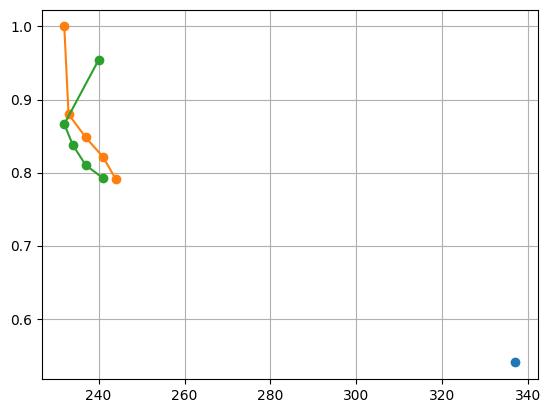

In [92]:

print(schedules[0])
print(len(schedules))
print("Evaluating schedules...")
schedules_split = [schedules[0:len(schedules)//2], schedules[len(schedules)//2:]]
print(len(schedules_split[0]), len(schedules_split[1]))

for schedules in schedules_split:
    for i, s in enumerate(schedules):
        utility, n, n_zero = evaluate_schedule(s)
        prop_zero = n_zero / n    
        print(f"Delay: {delays[i]} Utility: {utility} N: {n} N_zero: {n_zero}, Prop_zero: {prop_zero}")
    
prop_zero_gs = [1 - n_zero / n for utility, n, n_zero in [evaluate_schedule(s) for s in schedules_split[0]]]
total_gs = [n for utility, n, n_zero in [evaluate_schedule(s) for s in schedules_split[0]]]

prop_zero = [1 - n_zero / n for utility, n, n_zero in [evaluate_schedule(s) for s in schedules_split[1]]]
total = [n for utility, n, n_zero in [evaluate_schedule(s) for s in schedules_split[1]]]

print(total, prop_zero)
print(total_gs, prop_zero_gs)

# Conventional
utility, n, n_zero = evaluate_schedule(schedule_conventional)
prop_zero_conventional = 1 - n_zero / n
print(n, prop_zero_conventional)
plt.plot(n, prop_zero_conventional, 'o')

# Omniscient
utility, n, n_zero = evaluate_schedule(schedule_omniscient)
prop_zero_omniscient = 1 - n_zero / n
print(n, prop_zero_omniscient)
plt.plot(n, prop_zero_omniscient, '*', color='gold')
plt.plot(total, prop_zero, marker='o', label="Realtime")
plt.plot(total_gs, prop_zero_gs, marker='o', label="Ground Station")
plt.grid()
plt.show()